Lets verify data split

In [ ]:
from vpr_model import VPRModel
from dataloaders.MapsDataloader import MapsDataModule

import pandas as pd
import os
from PIL import Image
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from pandas import DataFrame
import datetime
from matplotlib import pyplot as plt

import utm
import cv2
from typing import List, Dict, Tuple, Optional

In [15]:

visloc_satelite_shandan_output_csv = '/workspace/repos/drone-loc-no-gps/Dataframes/Shandan.csv'
visloc_taizhou = '/home/user/PycharmProjects/mgr-repack/Dataframes/Taizhou-1.csv'
visloc_taizhou_out = '/home/user/PycharmProjects/mgr-repack/Dataframes/Taizhou-1_out.csv'
df = pd.read_csv(visloc_taizhou)

In [16]:
def get_utm(row):
    e, n, zone_num, zone_let = utm.from_latlon(row.lat, row.lon)
    zone = f'{zone_num}{zone_let or ""}'

    return {'e_utm': e, 'n_utm': n, 'zone_utm': zone}

In [ ]:
df = df.join(df.apply(get_utm, axis=1).apply(pd.Series))

In [ ]:
# APPLY IS NOT REQUIRED
df.to_csv(visloc_taizhou_out, index=True)
df = pd.read_csv(visloc_taizhou_out)

In [ ]:
# satellite_records = df[df['friendly-name'].str.contains('satellite')]
satellite_records = df[~df['friendly-name'].str.contains('uav')]
uav_records = df[df['friendly-name'].str.contains('uav')]

In [23]:
common_place_ids = set(satellite_records['place_id']).intersection(set(uav_records['place_id']))
if not common_place_ids:
    print("The same place_id for satellite and uav not found")

In [24]:
first_common_place_id = sorted(common_place_ids)[0]

In [ ]:
satellite_series = satellite_records[satellite_records['place_id'] == first_common_place_id]
uav_series = uav_records[uav_records['place_id'] == first_common_place_id]

Liczba wierszy w satellite_series: 1


In [60]:
def get_neigbourhood(series, df: DataFrame, range: int = 100):
    if isinstance(series, pd.DataFrame):
        if len(series) == 0:
            return pd.DataFrame()
        series = series.iloc[0]
    
    e_center = series['e_utm']
    n_center = series['n_utm'] 
    zone = series['zone_utm']
    
    neighbours = df[(
        df['e_utm'].between(e_center-range, e_center+range) &
        df['n_utm'].between(n_center-range, n_center+range) &
        (df['zone_utm'] == zone)
        )]
    return neighbours

In [62]:
satellite_related = get_neigbourhood(satellite_series, satellite_records)
print(len(satellite_related))
uav_related = get_neigbourhood(uav_series, uav_records)
print(len(uav_related))

9
3


In [66]:
def _ensure_series(s):
    if isinstance(s, pd.DataFrame):
        if len(s) == 0:
            raise ValueError("Empty DataFrame passed as center")
        return s.iloc[0]
    return s

def _infer_step_from_deltas(deltas: np.ndarray) -> Optional[float]:
    vals = np.unique(np.round(np.abs(deltas[np.abs(deltas) > 1e-6]), 6))
    vals = vals[vals > 0]
    if vals.size == 0:
        return None
    k = min(3, vals.size)
    return float(np.median(vals[:k]))

def _map_axis(delta: float, step: Optional[float], tol_ratio: float, grid_radius: int) -> Tuple[int, float, bool]:
   
    if step is None:
        return 0, abs(delta), True
    idx = int(np.clip(np.round(delta / step), -grid_radius, grid_radius))
    target = idx * step
    residual = abs(delta - target)
    tol = step * tol_ratio
    ok = residual <= tol
    return idx, residual, ok

def build_grid_from_df(neighbours_df: pd.DataFrame,
                       center_series: pd.Series,
                       e_col: str = 'e_utm',
                       n_col: str = 'n_utm',
                       path_col: str = 'path',
                       grid_radius: int = 1,           # 1 ⇒ 3x3, 2 ⇒ 5x5 itd.
                       step_e: Optional[float] = None,
                       step_n: Optional[float] = None,
                       tol_ratio: float = 0.5,
                       prefer_col: Optional[str] = None  # np. 'timestamp' do tie-breaku
                       ) -> Tuple[Dict[Tuple[int, int], pd.Series], Tuple[Optional[float], Optional[float]]]:
    """
    Zwraca:
      - grid: mapę {(gi, gj) -> wiersz (Series)} z gi: N(+)/S(-), gj: W(-)/E(+)
      - (step_e, step_n): użyte kroki w metrach
    """
    center = _ensure_series(center_series)
    e0, n0 = float(center[e_col]), float(center[n_col])

    df = neighbours_df.copy()

    candidates = df[[e_col, n_col]].to_numpy()
    dE_all = candidates[:, 0] - e0
    dN_all = candidates[:, 1] - n0

    if step_e is None:
        step_e = _infer_step_from_deltas(dE_all)
    if step_n is None:
        step_n = _infer_step_from_deltas(dN_all)

    grid: Dict[Tuple[int, int], pd.Series] = {}
    costs: Dict[Tuple[int, int], Tuple[float, float]] = {}  # (sum_residuals2, prefer_metric)

    grid[(0, 0)] = center
    costs[(0, 0)] = (0.0, 0.0)

    for idx, row in df.iterrows():
        dE = float(row[e_col]) - e0
        dN = float(row[n_col]) - n0

        gi, rN, okN = _map_axis(dN, step_n, tol_ratio, grid_radius)  # pion
        gj, rE, okE = _map_axis(dE, step_e, tol_ratio, grid_radius)  # poziom

        if not (okN and okE):
            continue
        if abs(gi) > grid_radius or abs(gj) > grid_radius:
            continue

        pos = (gi, gj)
        cost = rN * rN + rE * rE
        # prefer_metric: jeśli jest prefer_col, użyj do tie-breaku (np. większy timestamp wygrywa)
        prefer_metric = float(row[prefer_col]) if prefer_col in row and prefer_col is not None else 0.0

        if pos not in grid:
            grid[pos] = row
            costs[pos] = (cost, prefer_metric)
        else:
            curr_cost, curr_pref = costs[pos]
            # Wybierz lepszego: mniejszy błąd; przy remisie bierz większy prefer_metric
            if (cost < curr_cost - 1e-9) or (abs(cost - curr_cost) <= 1e-9 and prefer_metric > curr_pref):
                grid[pos] = row
                costs[pos] = (cost, prefer_metric)

    return grid, (step_e, step_n)

def _find_path_col(df: pd.DataFrame, fallback: Optional[str] = None) -> str:
    if fallback and fallback in df.columns:
        return fallback
    candidates = ['path', 'filepath', 'image_path', 'img_path', 'file', 'uri']
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError("Nie znalazłem kolumny z ścieżką do obrazu. Podaj path_col explicite.")

def _load_ref_shape(center_series: pd.Series, grid: Dict[Tuple[int, int], pd.Series], path_col: str) -> Tuple[int, int]:
    paths_to_try = []
    if path_col in center_series and pd.notna(center_series[path_col]):
        paths_to_try.append(center_series[path_col])
    for _, row in grid.items():
        if path_col in row and pd.notna(row[path_col]):
            paths_to_try.append(row[path_col])

    for p in paths_to_try:
        img = cv2.imread(str(p), cv2.IMREAD_COLOR)
        if img is not None:
            h, w = img.shape[:2]
            return h, w
    # Fallback
    return 512, 512

def concat_grid_with_placeholders_df(grid: Dict[Tuple[int, int], pd.Series],
                                     center_series: pd.Series,
                                     path_col: str = 'path',
                                     grid_radius: int = 1,
                                     fill_color: Tuple[int, int, int] = (0, 0, 0)) -> np.ndarray:
    center_series = _ensure_series(center_series)

    any_df = pd.concat([center_series.to_frame().T] + [s.to_frame().T for s in grid.values()],
                       ignore_index=True, sort=False)
    
    path_col = _find_path_col(any_df, fallback=path_col)

    # Wymiary docelowe
    ref_h, ref_w = _load_ref_shape(center_series, grid, path_col)
    blank = np.full((ref_h, ref_w, 3), fill_color, dtype=np.uint8)

    def load_resize(path: str) -> np.ndarray:
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None:
            return blank.copy()
        if img.shape[:2] != (ref_h, ref_w):
            img = cv2.resize(img, (ref_w, ref_h), interpolation=cv2.INTER_AREA)
        return img

    list_2d = []
    for gi in range(grid_radius, -grid_radius - 1, -1):
        row_imgs = []
        for gj in range(-grid_radius, grid_radius + 1):
            row = grid.get((gi, gj))
            if row is None or path_col not in row or pd.isna(row[path_col]):
                row_imgs.append(blank.copy())
            else:
                row_imgs.append(load_resize(row[path_col]))
        list_2d.append(row_imgs)

    rows = [cv2.hconcat(r) for r in list_2d]
    return cv2.vconcat(rows)

def make_mosaic_3x3_from_df(neighbours_df: pd.DataFrame,
                            center_series: pd.Series,
                            e_col: str = 'e_utm',
                            n_col: str = 'n_utm',
                            path_col: str = 'path',
                            tol_ratio: float = 0.5,
                            step_e: Optional[float] = None,
                            step_n: Optional[float] = None,
                            fill_color: Tuple[int, int, int] = (0, 0, 0)) -> Tuple[np.ndarray, Dict[Tuple[int, int], pd.Series], Tuple[Optional[float], Optional[float]]]:
    grid, steps = build_grid_from_df(
        neighbours_df, center_series,
        e_col=e_col, n_col=n_col, path_col=path_col,
        grid_radius=1, step_e=step_e, step_n=step_n, tol_ratio=tol_ratio
    )
    mosaic = concat_grid_with_placeholders_df(grid, center_series, path_col=path_col, grid_radius=1, fill_color=fill_color)
    return mosaic, grid, steps

[ WARN:0@1325.572] global loadsave.cpp:275 findDecoder imread_('/workspace/repos/datasets/train_thumbnails/Taizhou-1/patch__32_34707935214744__119_82755577499145__32_34647852015797__119_82815660207454__937216e242b24f1f94e3bc71eeddd0cf.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1325.573] global loadsave.cpp:275 findDecoder imread_('/workspace/repos/datasets/train_thumbnails/Taizhou-1/patch__32_34707935214744__119_82755577499145__32_34647852015797__119_82815660207454__937216e242b24f1f94e3bc71eeddd0cf.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1325.590] global loadsave.cpp:275 findDecoder imread_('/workspace/repos/datasets/train_thumbnails/Taizhou-1/patch__32_34707935214744__119_82755577499145__32_34647852015797__119_82815660207454__937216e242b24f1f94e3bc71eeddd0cf.jpg'): can't open/read file: check file path/integrity


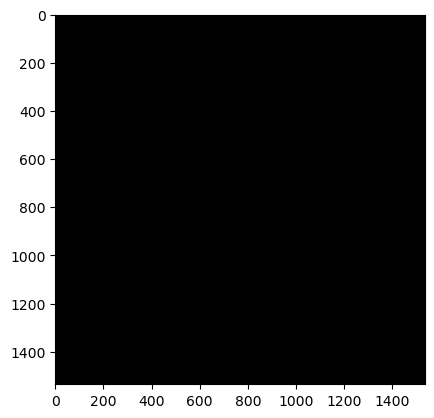

[ WARN:0@1325.936] global loadsave.cpp:275 findDecoder imread_('/workspace/repos/datasets/train_thumbnails/Taizhou-1/patch__32_34680215__119_8279235__3ef47004637241fbb5ccb608659d709c.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1325.936] global loadsave.cpp:275 findDecoder imread_('/workspace/repos/datasets/train_thumbnails/Taizhou-1/patch__32_34680215__119_8279235__3ef47004637241fbb5ccb608659d709c.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1325.936] global loadsave.cpp:275 findDecoder imread_('/workspace/repos/datasets/train_thumbnails/Taizhou-1/patch__32_34730635__119_8270984__baf158892e004d89ad56c2d084420e5b.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1325.937] global loadsave.cpp:275 findDecoder imread_('/workspace/repos/datasets/train_thumbnails/Taizhou-1/patch__32_34628649__119_8287256__c6ebf9a0da9d4232aed91c7254f34166.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1325.938] global loadsave.cpp:275 findD

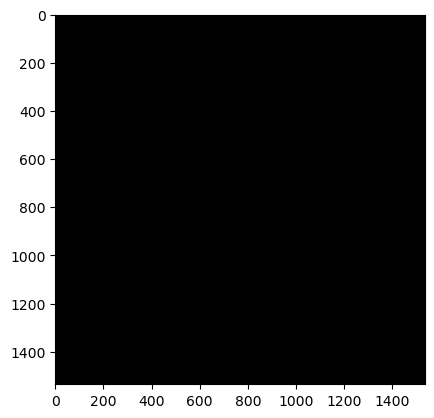

In [ ]:
sat_mosaic, sat_grid, (sat_step_e, sat_step_n) = make_mosaic_3x3_from_df(
    satellite_related, satellite_series,
    e_col='e_utm', n_col='n_utm', path_col='img_path', 
    tol_ratio=0.5,  # możesz np. 0.4-0.6
)

# cv2.imwrite('satellite_mosaic.png', sat_mosaic)
plt.imshow(sat_mosaic)
plt.show()

uav_mosaic, uav_grid, (uav_step_e, uav_step_n) = make_mosaic_3x3_from_df(
    uav_related, uav_series,
    e_col='e_utm', n_col='n_utm', path_col='img_path',
    tol_ratio=0.5,
)
# cv2.imwrite('uav_mosaic.png', uav_mosaic)
plt.imshow(uav_mosaic)
plt.show()